**Общая информация**

**Срок сдачи:** 29 марта 2021, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import ShuffleSplit

**Задание 1 (1 балл)**

Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    def __init__(self, n_neighbors, algorithm='brute'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes = np.unique(y)
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        else:
            self.mask = np.repeat(self.y_train, len(self.classes)).reshape(-1, len(self.classes))
            self.mask = self.mask == self.classes

    def _predict_brute(self, X):
        weights = 1 / cdist(X, self.X_train)
        idx = weights.argpartition(-self.n_neighbors, axis=1)
        np.put_along_axis(weights, idx[:, :-self.n_neighbors], axis=1, values=0)
        
        return self.classes[np.argmax(weights @ self.mask, axis=1)]
    
    def _predict_kd_tree(self, X):
        dist, idx = self.tree.query(X, k=self.n_neighbors)
        
        weights = 1 / dist
        weights_by_class = None
        
        y_train = self.y_train[idx]
        
        for c in self.classes:
            s = np.multiply(weights, y_train == c)
            s = np.sum(s, axis=1, keepdims=True)
            if weights_by_class is None:
                weights_by_class = s
            else:
                weights_by_class = np.concatenate((weights_by_class, s), axis=1)
        
        return self.classes[np.argmax(weights_by_class, axis=1)]
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            return self._predict_kd_tree(X)
        else:
            return self._predict_brute(X)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 726 µs, sys: 177 µs, total: 903 µs
Wall time: 645 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 88 µs, sys: 21 µs, total: 109 µs
Wall time: 70.6 µs


In [10]:
%time clf.predict(X_test)

CPU times: user 3.09 ms, sys: 40 µs, total: 3.13 ms
Wall time: 3.06 ms


array([2, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 540 µs, sys: 0 ns, total: 540 µs
Wall time: 331 µs


array([2, 2, 2, 1, 1, 1, 1, 0, 2, 0, 0, 2, 0, 1, 0])

**Задание 3 (1 балл)**

Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [12]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [14]:
%time clf.fit(X_train, y_train)

CPU times: user 2.35 ms, sys: 93 µs, total: 2.45 ms
Wall time: 1.9 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [15]:
%time my_clf.fit(X_train, y_train)

CPU times: user 356 µs, sys: 85 µs, total: 441 µs
Wall time: 419 µs


In [16]:
%time clf.predict(X_test)

CPU times: user 1.87 ms, sys: 210 µs, total: 2.08 ms
Wall time: 1.53 ms


array([2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2])

In [17]:
%time my_clf.predict(X_test)

CPU times: user 356 µs, sys: 0 ns, total: 356 µs
Wall time: 320 µs


array([2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 2, 0, 0, 0, 2])

In [18]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [19]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers', 'footers', 'quotes'])

In [20]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [21]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data, target)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [22]:
def splitter():
    return ShuffleSplit(n_splits=3)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей (дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [23]:
def _cross_val_score(estimator, X, y, cv):
    scores = []
    
    for train_index, test_index in cv.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]

        estimator.fit(X_train, y_train)
        predicted = estimator.predict(X_test)
        
        scores.append(np.mean(predicted == y[test_index]))
    
    return scores

def find_k(X, y, k_min=1, k_max=10, metric='minkowski'):
    scores = []
    
    for k in range(k_min, k_max + 1):
        rs = splitter()
        clf = KNeighborsClassifier(n_neighbors=k, metric=metric)
        scores.append(np.mean(_cross_val_score(clf, X, y, cv=rs)))
    
    return scores

def plot_scores(scores, k_min=1, k_max=10, title=''):
    x = np.arange(k_min, k_max + 1)
    
    plt.figure(figsize=(12, 6))
    plt.plot(x, scores, marker='o', markersize=6)
    plt.title(title)
    plt.xlabel('k соседей')
    plt.ylabel('Средняя точность')
    plt.xticks(x)
    plt.show()

In [24]:
import random

random.seed(123)

scores = find_k(X, target)
scores

[0.23380447585394581,
 0.2108362779740872,
 0.20111896348645464,
 0.19316843345111898,
 0.20111896348645464,
 0.19611307420494697,
 0.20259128386336867,
 0.21113074204947,
 0.20818610129564194,
 0.2040636042402827]

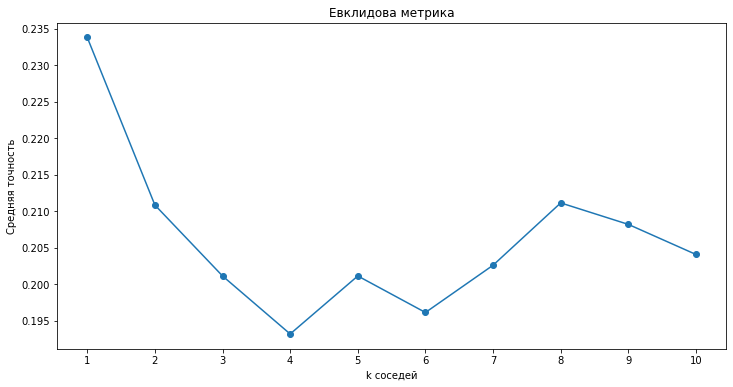

In [25]:
plot_scores(scores, title='Евклидова метрика')

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [26]:
scores = find_k(X, target, metric='cosine')
scores

[0.32302709069493524,
 0.30594817432273264,
 0.2979976442873969,
 0.2938751472320377,
 0.27385159010600707,
 0.28916372202591284,
 0.2712014134275618,
 0.2753239104829211,
 0.2482332155477032,
 0.26648998822143694]

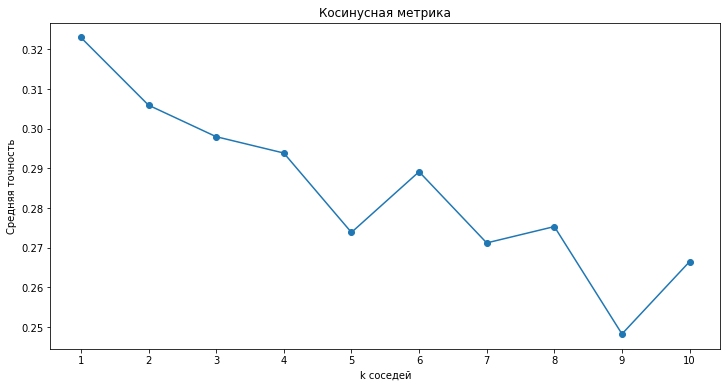

In [27]:
plot_scores(scores, title='Косинусная метрика')

In [28]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data, target)

In [29]:
scores = find_k(X, target)
scores

[0.17932862190812723,
 0.13162544169611307,
 0.11837455830388692,
 0.12338044758539457,
 0.10659599528857477,
 0.1083627797408716,
 0.10865724381625441,
 0.10689045936395758,
 0.09511189634864547,
 0.09746760895170788]

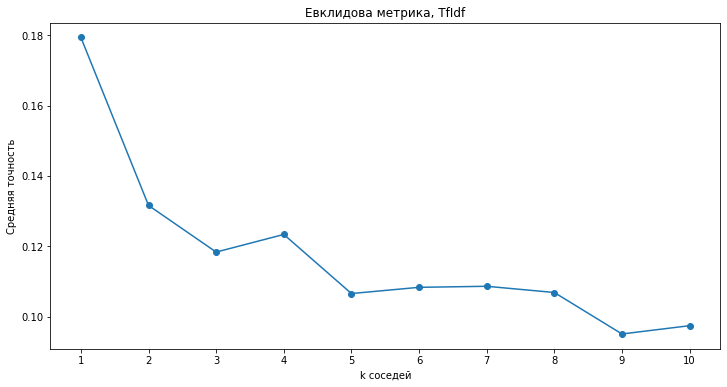

In [30]:
plot_scores(scores, title='Евклидова метрика, TfIdf')

In [31]:
scores = find_k(X, target, metric='cosine')
scores

[0.6251472320376914,
 0.6027679623085983,
 0.5977620730270906,
 0.6068904593639576,
 0.5951118963486455,
 0.6065959952885748,
 0.6048292108362779,
 0.5845111896348646,
 0.5980565371024736,
 0.5904004711425207]

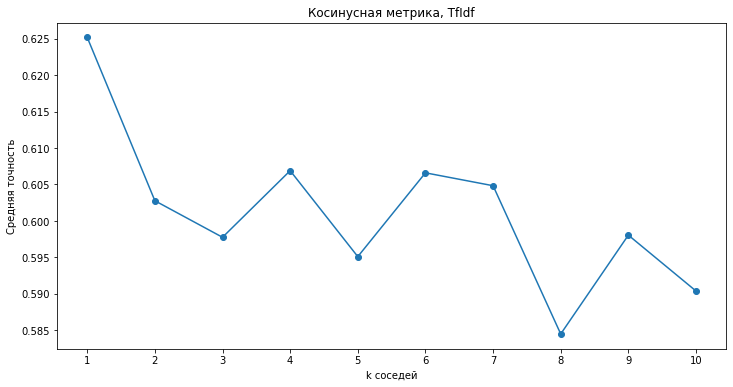

In [32]:
plot_scores(scores, title='Косинусная метрика, TfIdf')

Лучшая модель: k = 4, косинусная метрика, TfIdf векторизация.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [33]:
newsgroups = fetch_20newsgroups(subset='test', remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [34]:
data = newsgroups['data']
target = newsgroups['target']

In [35]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data, target)

In [36]:
clf = KNeighborsClassifier(n_neighbors=4, metric='cosine')
clf.fit(X, target)
np.mean(clf.predict(X) == target)

0.7547796070100903

Точность выше.